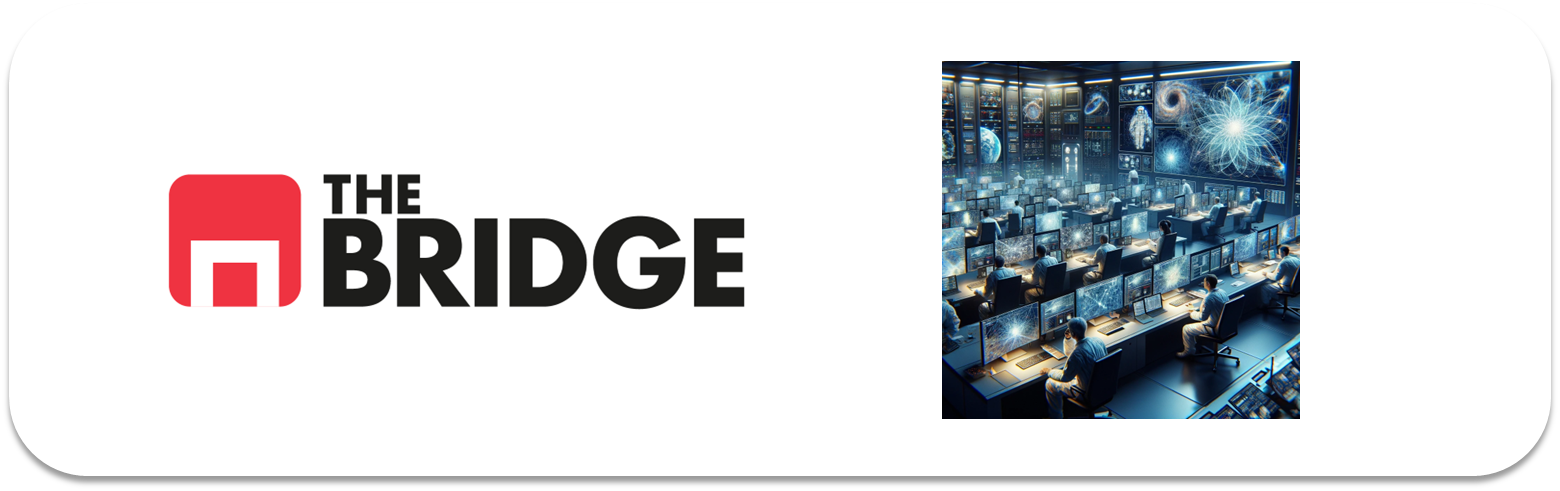

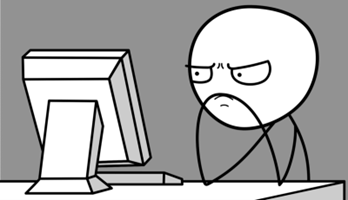

Para ejercitarte y afianzar lo aprendido sobre **Transfer Learning y Fine-tuning**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.utils import shuffle
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from tensorflow.keras import Model
import pandas as pd
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

## Apple 360

En este conjunto de ejercicios vas a montar un clasificador de manzanas mediante un dataset de imágenes. El dataset se compone de 13 tipos diferentes con aproximadamente unas 200 imágenes por cada tipo. Tendrás que montar un modelo de deep learning que utilice **transfer learning**. Se sugiere empezar con una red ResNet50 con imagenet.

El dataset original proviene del [concurso de Kaggle Fruits 360](https://www.kaggle.com/moltean/fruits), pero adaptado para la clasificación de una menor cantidad de casos (sólo las manzanas).


### Ejercicio 1

Crea los juegos de X,y para train y test a partir de los datos teninendo en cuenta su distribución, para ello tendrás que explorar las estructura. Crea un juego Train,test para resolución 32x32 y un juego de test adicional para 224x224. Es decir tendras que tener un X_train, X_test para 32x32 y un X_test adicional a 224x224

In [58]:
TRAIN_PATH = './data/apples/Train'
TEST_PATH = './data/apples/Test'

In [59]:
# Cargamos cada imagen y su etiqueta
X_train = []
y_train = []

for category in os.listdir(TRAIN_PATH):
    for file in os.listdir(os.path.join(TRAIN_PATH, category)):
        img = plt.imread(os.path.join(TRAIN_PATH, category, file))
        img = cv2.resize(img, (32, 32))
        X_train.append(img)
        y_train.append(category)

In [60]:
# Transformamos a numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

In [61]:
# Verificamos que la carga de datos sea correcta
print(X_train.shape)
print(y_train.shape)

(6404, 32, 32, 3)
(6404,)


In [62]:
# Cargamos los datos de test
X_test = []
y_test = []

for category in os.listdir(TEST_PATH):
    for file in os.listdir(os.path.join(TEST_PATH, category)):
        img = plt.imread(os.path.join(TEST_PATH, category, file))
        img = cv2.resize(img, (32, 32))
        X_test.append(img)
        y_test.append(category)

# Transformamos a numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)

In [63]:
# Verificamos que la carga de datos sea correcta
print(X_test.shape)
print(y_test.shape)

(2134, 32, 32, 3)
(2134,)


In [64]:
# Cargamos los datos de test
X_test_224 = []
y_test_224 = []

for category in os.listdir(TEST_PATH):
    for file in os.listdir(os.path.join(TEST_PATH, category)):
        img = plt.imread(os.path.join(TEST_PATH, category, file))
        img = cv2.resize(img, (224, 224))
        X_test_224.append(img)
        y_test_224.append(category)

# Transformamos a numpy arrays
X_test_224 = np.array(X_test_224)
y_test_224 = np.array(y_test_224)

In [65]:
print(X_test_224.shape)
print(y_test_224.shape)

(2134, 224, 224, 3)
(2134,)


**NOTA:** A partir de aquí emplea siempre el X_train, X_test de 32x32 salvo en el ejercicio que se te diga lo contrario.

### Ejercicio 2

Haz una visualización de algunos de los datos. Crea una función que te ayude con ello.

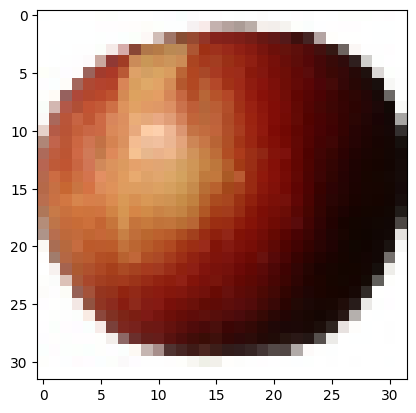

In [66]:
plt.imshow(X_train[0])

In [67]:
def show_images_batch(apples, names = [], n_cols = 5, size_scale = 2):
    n_rows = ((len(apples) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1*size_scale))
    for index, apple in enumerate(apples):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(apple)
        plt.axis("off")
        if len(names):
            plt.title(names[index])

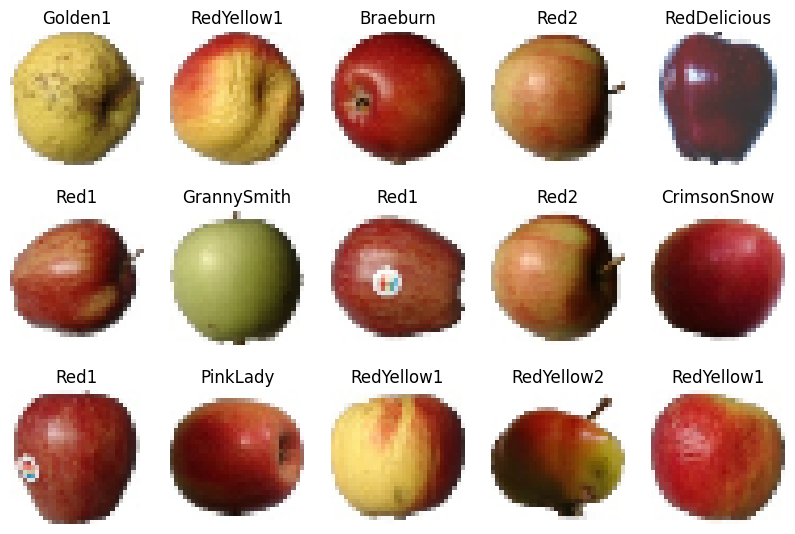

In [68]:
indices = np.random.randint(0,len(X_train),15)
show_images_batch(X_train[indices], y_train[indices])

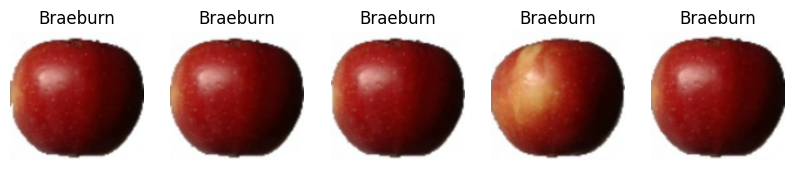

In [69]:
show_images_batch(X_test_224[23:28],y_test_224[23:28])

### Ejercicio 3

Completa el miniEDA habitual con imágenes y escoge una métrica para el modelo.

In [70]:
pd.Series(y_train).value_counts(normalize = True)

RedYellow2      0.104934
Golden2         0.076827
Red2            0.076827
GrannySmith     0.076827
Braeburn        0.076827
RedYellow1      0.076827
Red1            0.076827
RedDelicious    0.076515
Golden3         0.075109
Golden1         0.074953
PinkLady        0.071205
CrimsonSnow     0.069332
Red3            0.066989
Name: proportion, dtype: float64

### Ejercicio 4 

Termina de transformar los datos si crees que es conveniente y aunque el entrenamiento de modelos de keras ya tiene un shuffling interno, haz un "barajado" del X_train (del X_test no es necesario) para facilitar la convergencia inicial del modelo. Utiliza la función shuffle de sklearn y asigna la salida a un X_train distinto (es decir no machaques el inicial)

In [71]:
# Escalamos las imágenes
X_train = X_train / 255
X_test = X_test / 255

In [72]:
from sklearn.utils import shuffle
X_train_s, y_train_s = shuffle(X_train, y_train, random_state=42)

### Ejercicio 5

Sklearn permite trabajar con etiquetas textuales pero keras no. Transforma las etiquetas a numéricas, creando dos diccionarios uno que permita traducir de etiqueta a clase numérica y otro que permita la transformación inversa.

In [73]:
# Maopeamos las categorías a números
categorias = np.unique(y_train)
n_categorias = len(categorias)

mapping = {cat: i for i, cat in enumerate(categorias)}
inverse_mapping = {valor:clave for clave,valor in mapping.items()}

In [74]:
# Observamos el mapeo
mapping

{np.str_('Braeburn'): 0,
 np.str_('CrimsonSnow'): 1,
 np.str_('Golden1'): 2,
 np.str_('Golden2'): 3,
 np.str_('Golden3'): 4,
 np.str_('GrannySmith'): 5,
 np.str_('PinkLady'): 6,
 np.str_('Red1'): 7,
 np.str_('Red2'): 8,
 np.str_('Red3'): 9,
 np.str_('RedDelicious'): 10,
 np.str_('RedYellow1'): 11,
 np.str_('RedYellow2'): 12}

In [75]:
inverse_mapping

{0: np.str_('Braeburn'),
 1: np.str_('CrimsonSnow'),
 2: np.str_('Golden1'),
 3: np.str_('Golden2'),
 4: np.str_('Golden3'),
 5: np.str_('GrannySmith'),
 6: np.str_('PinkLady'),
 7: np.str_('Red1'),
 8: np.str_('Red2'),
 9: np.str_('Red3'),
 10: np.str_('RedDelicious'),
 11: np.str_('RedYellow1'),
 12: np.str_('RedYellow2')}

In [76]:
# Mapeamos las etiquetas
y_train_num = np.array([mapping[cat] for cat in y_train_s])
y_test_num = np.array([mapping[cat] for cat in y_test])

### Ejercicio 6: Zero Shot Learning

Descar el modelo ResNet50 preparado ya para poder usarlo directamente a la Zero Shot Learning. Pruébalo contra el test (aquí no valen nuestras categorías serán las que proporcione ResNet ojo). Prueba una selección aleatoria de imágenes del test y compara las etiquetas de ResNet con la que tiene. ¿Nos sirve este clasificador así tal cual?

In [77]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, decode_predictions, preprocess_input

In [78]:
base_model = ResNet50V2(input_shape=(224, 224,3),
                        include_top=True, # Como vamos a emplearla directamente, incluimos también la parte de capas densas que hacen la predicción en este caso clasificación de imagenes 
                        weights="imagenet", # Se carga con los pesos entrenados para el dataset de imagenet
                        classifier_activation="softmax")

In [79]:
preds = base_model.predict(X_test_224)

67/67 ━━━━━━━━━━━━━━━━━━━━ 33s 475ms/step


In [80]:
seleccion = np.random.randint(0,len(X_test_224),20)

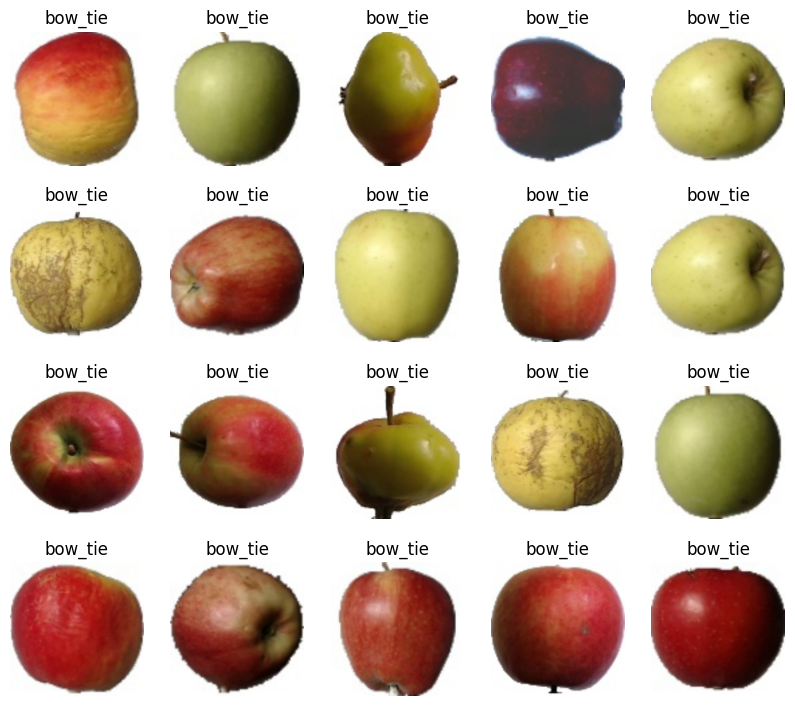

In [81]:
clase = [decodificado[0][1] for decodificado in decode_predictions(preds)]
show_images_batch(X_test_224[seleccion], names = clase)

## Transfer Learning

### Ejercicio 7:

Carga la ResNet50 sin cabezas, crea un modelo con el anterior y una cabeza con dos capas densas, una oculta de 300 unidades (con activación "relu") y otra de salida con las unidades que crees necesarias y activación la que consideres. Congela las capas del modelo base (la ResNet50). Define también los hiperparámetros necesarios para compilar y compila el modelo y muestra un summary del mismo.

In [82]:
# Cargamos el modelo pre-entrenado
base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(32, 32, 3))

# Congelamos sus capas
for layer in base_model.layers:
    layer.trainable = False

# Capa de flatenizado de la salida del modelo base
def prepare_model(base_model = base_model): # Lo creamos así para poder reinicializarlo en cada reentrenamiento en ejercicios posteriores
    x = layers.Flatten()(base_model.output)
    
    # Capa densa con 300 neuronas
    x = layers.Dense(300, activation='relu')(x)
    x = layers.Dropout(rate = 0.5)(x)

    
    # Capa final de salida con 13 neuronas y activación softmax
    x = layers.Dense(13, activation='softmax')(x)
    
    model = Model(base_model.input, x)
    model.compile(optimizer = "adam", loss = 'sparse_categorical_crossentropy', metrics = ['acc'])
    return model
# Observamos la arquitectura del modelo
model= prepare_model()
model.summary()



Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 38, 38, 3) │          0 │ input_layer_6[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 16, 16,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 18, 18,    │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 8, 8, 64)  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 8, 8, 64)  │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 8, 8, 64)  │          0 │ conv2_block1_pre… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 8, 8, 64)  │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_1_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 10, 10,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 8, 8, 64)  │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_2_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 8, 8, 256) │          0 │ conv2_block1_0_c

 Total params: 24,183,413 (92.25 MB)

 Trainable params: 618,613 (2.36 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [83]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 38, 38, 3) │          0 │ input_layer_6[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 16, 16,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 18, 18,    │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 8, 8, 64)  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 8, 8, 64)  │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 8, 8, 64)  │          0 │ conv2_block1_pre… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 8, 8, 64)  │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_1_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 10, 10,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 8, 8, 64)  │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_2_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 8, 8, 256) │          0 │ conv2_block1_0_c

 Total params: 24,183,413 (92.25 MB)

 Trainable params: 618,613 (2.36 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

### Ejercicio 8

Entrena el modelo con nuestros datos de train y muestra la evolución del entrenamiento. Emplea un callback de Earlystopping con patience a 5. Termina de escoger el batch_size y el número de épocas.

In [84]:
earlyS = EarlyStopping(patience= 5, restore_best_weights= True)

In [85]:
X_train_s.shape

(6404, 32, 32, 3)

In [86]:
instancias_train = len(X_train)
for i in range(1,5):
    print(f"Batch_size: {32*i}, num_steps_per_epoch: {round(instancias_train/(32*i))}")

Batch_size: 32, num_steps_per_epoch: 200
Batch_size: 64, num_steps_per_epoch: 100
Batch_size: 96, num_steps_per_epoch: 67
Batch_size: 128, num_steps_per_epoch: 50


In [87]:
batch_size = 64

In [88]:
# Entrenamos el modelo
from time import time
t_zero = time()
model = prepare_model()
history = model.fit(X_train_s, 
                    y_train_num,
                    batch_size = batch_size,
                    validation_split=0.2,
                    epochs=1,)
print(time() - t_zero)

81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - acc: 0.4787 - loss: 2.0246 - val_acc: 0.9352 - val_loss: 0.2752
9.865111589431763


In [89]:
# Entrenamos el modelo
model = prepare_model()
history = model.fit(X_train_s, 
                    y_train_num,
                    batch_size = batch_size,
                    validation_split=0.2,
                    epochs=20,
                   callbacks=[earlyS])

Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - acc: 0.4694 - loss: 2.0328 - val_acc: 0.9524 - val_loss: 0.2463
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - acc: 0.9034 - loss: 0.3124 - val_acc: 0.9844 - val_loss: 0.1036
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - acc: 0.9598 - loss: 0.1631 - val_acc: 0.9883 - val_loss: 0.0676
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - acc: 0.9746 - loss: 0.1098 - val_acc: 0.9992 - val_loss: 0.0334
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - acc: 0.9806 - loss: 0.0747 - val_acc: 0.9992 - val_loss: 0.0228
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - acc: 0.9942 - loss: 0.0452 - val_acc: 0.9992 - val_loss: 0.0150
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - acc: 0.9908 - loss: 0.0440 - val_acc: 0.9992 - val_loss: 0.0118
Epoch 8/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - acc: 0.9947 - loss: 0.0314 - val_acc: 1.0000 - val_loss: 0.0070
Epoch 9/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - acc: 0.991

In [90]:
evol = pd.DataFrame(history.history)

<Axes: >

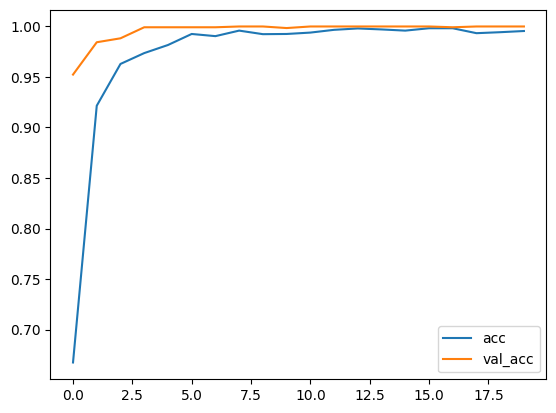

In [91]:
evol[["acc","val_acc"]].plot()

<Axes: >

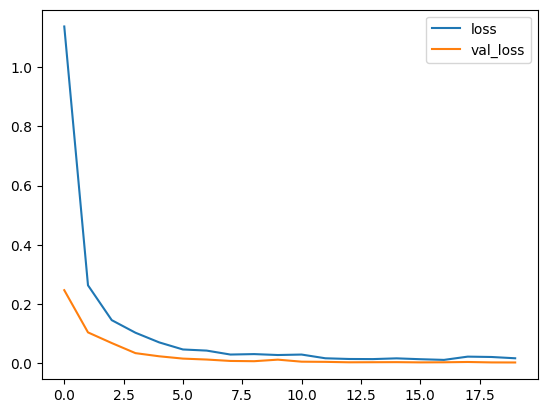

In [92]:
evol[["loss","val_loss"]].plot()

In [93]:
earlyS = EarlyStopping(min_delta = 0.001, restore_best_weights= True)

### Ejercicio 9

Evalua el modelo contra test y haz un pequeño análisis de las diferencias. Haz un clasification report y muestra la matriz de confusion. Haz un pequeño análisis de errores.

In [94]:
# Evaluamos el modelo
model.evaluate(X_test, y_test_num)

67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - acc: 0.8746 - loss: 0.4595


[0.539313793182373, 0.8608247637748718]

In [95]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

y_pred = [inverse_mapping[np.argmax(prediccion)] for prediccion in model.predict(X_test)]
print(classification_report(y_test, y_pred))

67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step
              precision    recall  f1-score   support

    Braeburn       0.81      0.85      0.83       164
 CrimsonSnow       0.77      0.95      0.85       148
     Golden1       0.72      1.00      0.84       160
     Golden2       0.99      0.96      0.98       164
     Golden3       0.69      0.61      0.65       161
 GrannySmith       1.00      0.79      0.88       164
    PinkLady       0.84      0.77      0.80       152
        Red1       0.98      0.75      0.85       164
        Red2       0.62      0.78      0.69       164
        Red3       0.91      0.78      0.84       144
RedDelicious       1.00      1.00      1.00       166
  RedYellow1       1.00      0.94      0.97       164
  RedYellow2       1.00      0.96      0.98       219

    accuracy                           0.86      2134
   macro avg       0.87      0.86      0.86      2134
weighted avg       0.88      0.86      0.86      2134



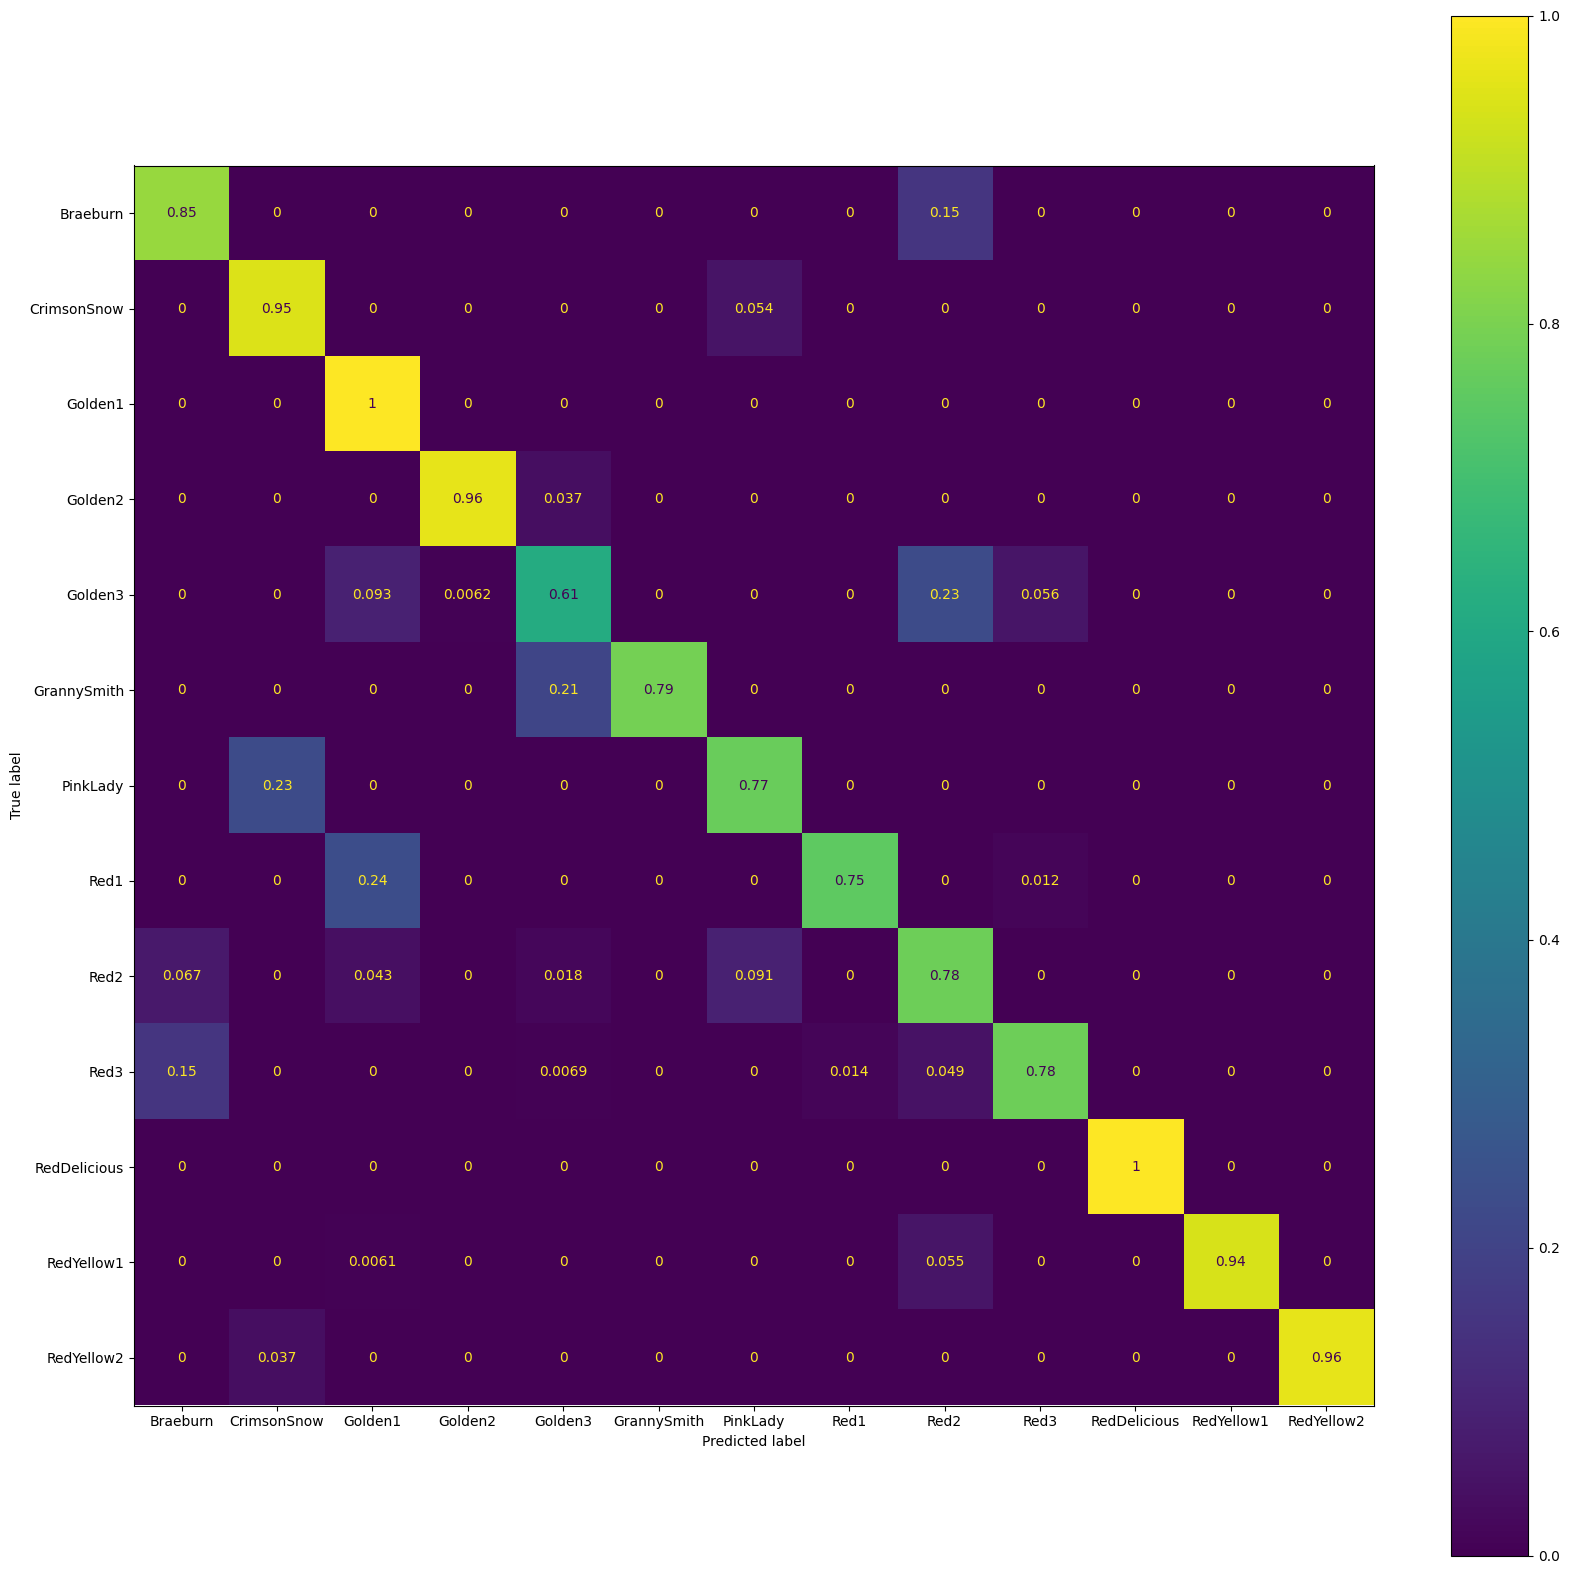

In [96]:
fig,axs = plt.subplots(1,1,figsize = (20,20))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize = "true", ax = axs)

In [97]:
resultados = pd.DataFrame({"True": y_test, "Predicted": y_pred})

In [98]:
errores = resultados["True"] != resultados["Predicted"]
es_Golden3 = resultados["True"] == "Golden3"
predicted_Red2 = resultados["Predicted"] == "Red2"
es_Red2 = resultados["True"] == "Red2"

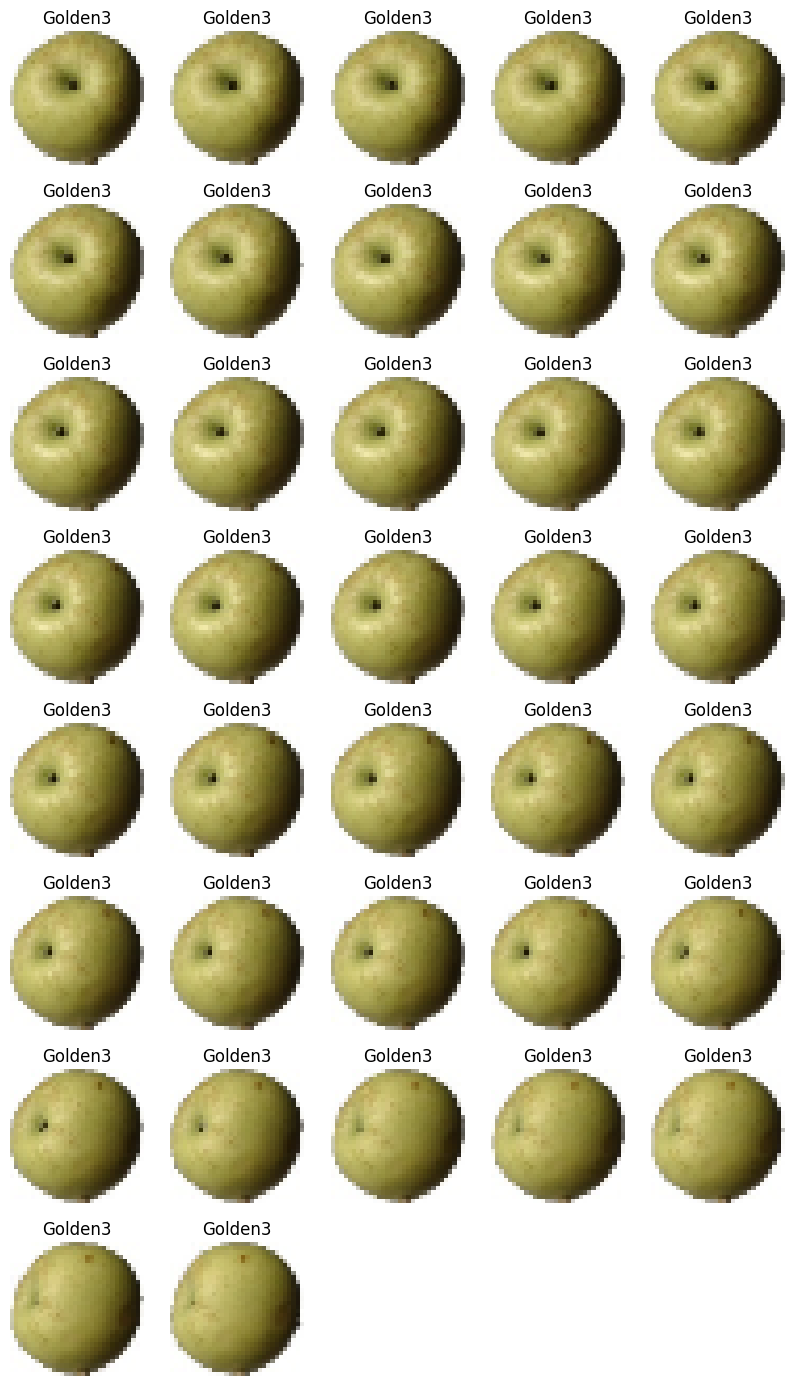

In [99]:
show_images_batch(X_test[resultados[es_Golden3 & predicted_Red2].index], y_test[resultados[es_Golden3 & predicted_Red2].index])

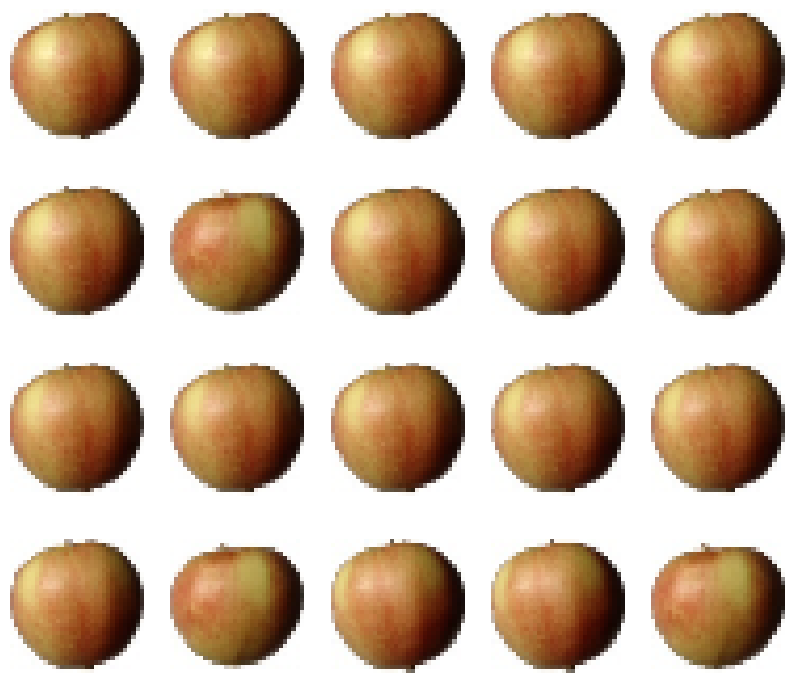

In [100]:
show_images_batch(X_test[resultados[es_Red2 & predicted_Red2].index[20:40]])

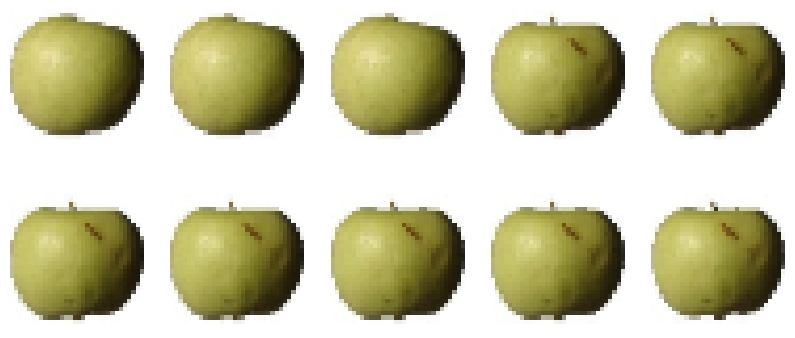

In [101]:
show_images_batch(X_test[resultados[es_Golden3 & (errores == False)].index[0:10]])

## Fine Tuning

### Ejercicio 10

Vuelve a descargar el modelo ResNet50 pero sin pesos entrenados, ni cabeza, crea el mismo modelo personalizado que en el ejercicio 7, compila y muestra el summary.

In [102]:
# Cargamos el modelo pre-entrenado
base_model = ResNet50V2(include_top=False, weights= None, input_shape=(32, 32, 3))

# Capa de flatenizado de la salida del modelo base
def prepare_model(base_model = base_model): # Lo creamos así para poder reinicializarlo en cada reentrenamiento en ejercicios posteriores
    x = layers.Flatten()(base_model.output)
    
    # Capa densa con 300 neuronas
    x = layers.Dense(300, activation='relu')(x)
    x = layers.Dropout(rate = 0.5)(x)

    
    # Capa final de salida con 13 neuronas y activación softmax
    x = layers.Dense(13, activation='softmax')(x)
    
    model = Model(base_model.input, x)
    model.compile(optimizer = "adam", loss = 'sparse_categorical_crossentropy', metrics = ['acc'])
    return model
# Observamos la arquitectura del modelo
model= prepare_model()
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 38, 38, 3) │          0 │ input_layer_7[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 16, 16,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 18, 18,    │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 8, 8, 64)  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 8, 8, 64)  │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 8, 8, 64)  │          0 │ conv2_block1_pre… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 8, 8, 64)  │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_1_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 10, 10,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 8, 8, 64)  │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_2_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 8, 8, 256) │          0 │ conv2_block1_0_c

 Total params: 24,183,413 (92.25 MB)

 Trainable params: 24,137,973 (92.08 MB)

 Non-trainable params: 45,440 (177.50 KB)

### Ejercicio 11
Entrena con batch_size a 64 y 60 épocas, con un EarlyStopping de patience a 10 (ahora el entrenamiento es sensiblemente más largo, así que tómate un descanso). Muestra la evolución y da una posible justificación a emplear tantas épocas de partida.

In [103]:
earlySFT = EarlyStopping(restore_best_weights= True, patience= 10)

In [104]:
model = prepare_model()
history = model.fit(X_train_s, 
                    y_train_num,
                    batch_size = batch_size,
                    validation_split=0.2,
                    epochs=60,
                   callbacks=[earlySFT])

Epoch 1/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 37s 305ms/step - acc: 0.6534 - loss: 1.1378 - val_acc: 0.0695 - val_loss: 3.9026
Epoch 2/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 22s 269ms/step - acc: 0.9130 - loss: 0.3233 - val_acc: 0.1483 - val_loss: 9.4706
Epoch 3/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 22s 267ms/step - acc: 0.8890 - loss: 0.3942 - val_acc: 0.0695 - val_loss: 23.8310
Epoch 4/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 263ms/step - acc: 0.8798 - loss: 0.4006 - val_acc: 0.0898 - val_loss: 34.4738
Epoch 5/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 22s 267ms/step - acc: 0.9509 - loss: 0.1696 - val_acc: 0.1811 - val_loss: 15.6411
Epoch 6/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 22s 267ms/step - acc: 0.9505 - loss: 0.2056 - val_acc: 0.4941 - val_loss: 5.0337
Epoch 7/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 22s 266ms/step - acc: 0.9393 - loss: 0.2612 - val_acc: 0.9594 - val_loss: 0.1180
Epoch 8/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 22s 268ms/step - acc: 0.9907 - loss: 0.0297 - val_acc: 0.9711 - val_loss: 0.0769
Epoch 9/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 22s 277

<Axes: >

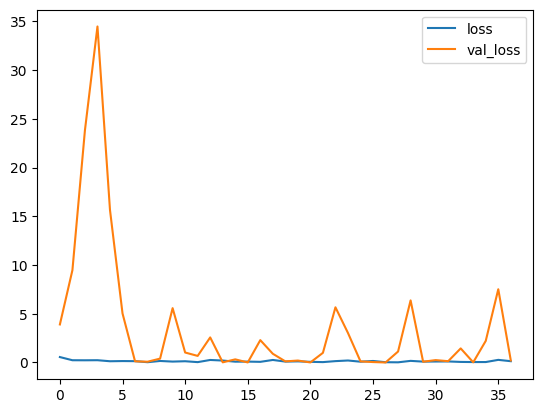

In [105]:
df_evol = pd.DataFrame(history.history)
df_evol[["loss","val_loss"]].plot()

### Ejercicio 12

Muestra la evaluación contra el test, el informe de clasificación  y la matriz de confusión. Compara los resultados con los del ejercicio 9.

In [106]:
model.evaluate(X_test, y_test_num)

67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - acc: 0.9802 - loss: 0.0624


[0.03541635349392891, 0.9896907210350037]

In [107]:
y_pred = [inverse_mapping[np.argmax(prediccion)] for prediccion in model.predict(X_test)]
print(classification_report(y_test, y_pred))

67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step
              precision    recall  f1-score   support

    Braeburn       0.96      0.91      0.93       164
 CrimsonSnow       1.00      1.00      1.00       148
     Golden1       1.00      1.00      1.00       160
     Golden2       1.00      1.00      1.00       164
     Golden3       1.00      1.00      1.00       161
 GrannySmith       1.00      1.00      1.00       164
    PinkLady       1.00      1.00      1.00       152
        Red1       1.00      0.99      1.00       164
        Red2       0.92      0.96      0.94       164
        Red3       0.99      1.00      1.00       144
RedDelicious       1.00      1.00      1.00       166
  RedYellow1       1.00      1.00      1.00       164
  RedYellow2       1.00      1.00      1.00       219

    accuracy                           0.99      2134
   macro avg       0.99      0.99      0.99      2134
weighted avg       0.99      0.99      0.99      2134



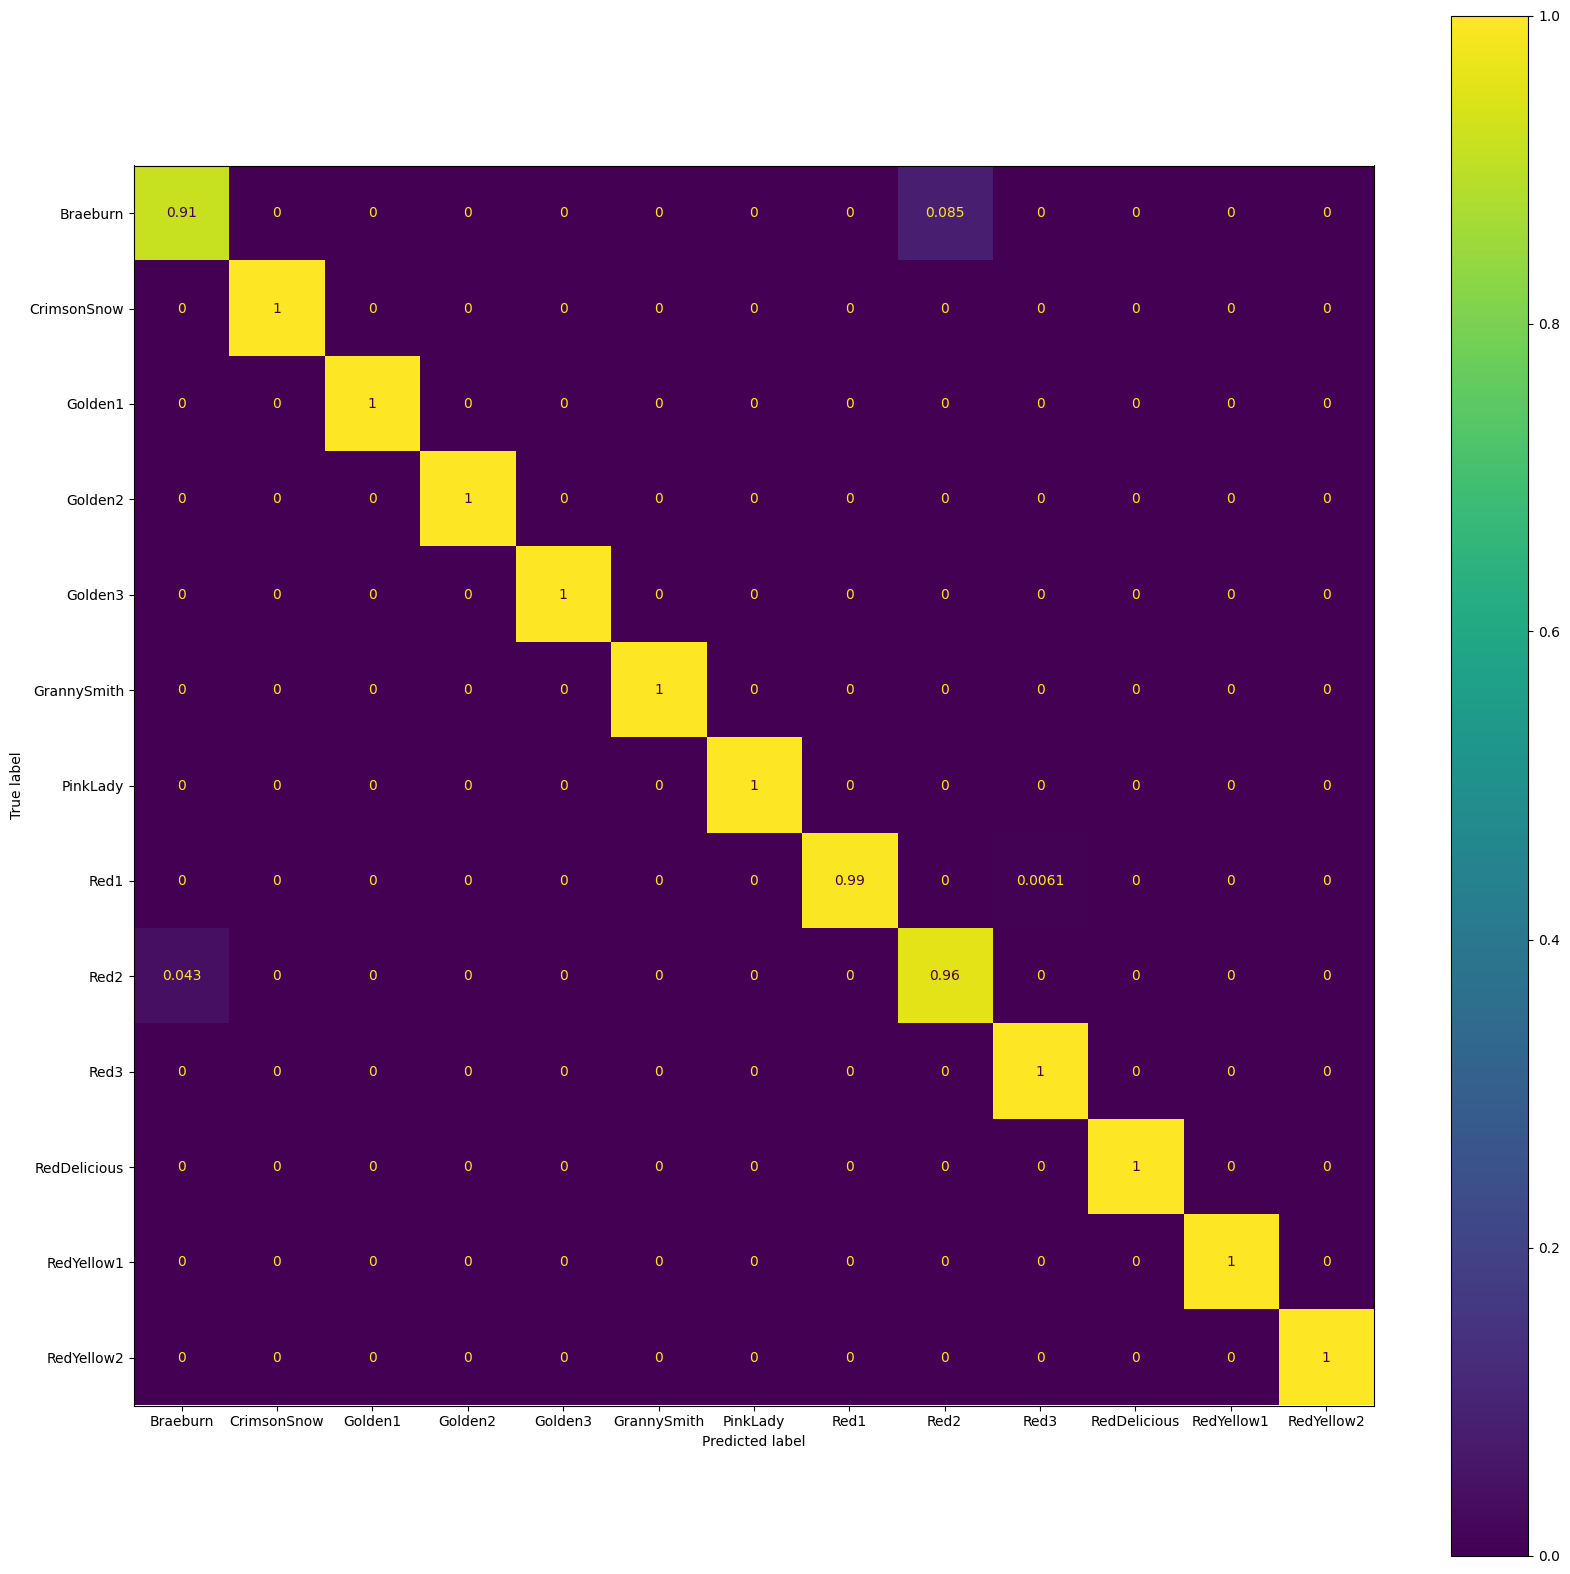

In [108]:
fig,axs = plt.subplots(1,1,figsize = (20,20))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize = "true", ax = axs)